In [39]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.33.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [34]:
!git clone https://github.com/hansk88/Capstone-Project-ML.git

fatal: destination path 'Capstone-Project-ML' already exists and is not an empty directory.


In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # Untuk membagi data secara manual
import shutil # Untuk operasi file/folder

In [36]:
# ---Konfigurasi Dasar---
DATA_DIR = '/content/Capstone-Project-ML/Dataset Makanan'
IMG_HEIGHT = 320
IMG_WIDTH = 320
BATCH_SIZE = 8
VALIDATION_SPLIT = 0.2
SEED = 42 # Untuk reproduktifitas hasil

In [37]:
# --Persiapan Dataset---
all_image_paths = []
all_labels = []
if not os.path.isdir(DATA_DIR):
    print(f"Error: Direktori '{DATA_DIR}' tidak ditemukan.")
    print("Pastikan folder ini ada dan berada di lokasi yang sama dengan skrip Anda.")
    exit()

class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
num_classes = len(class_names)

if num_classes == 0:
    print(f"Error: Tidak ada sub-folder (kategori makanan) ditemukan di '{DATA_DIR}'.")
    print("Pastikan struktur folder Anda seperti 'Dataset Makanan/nasi_goreng/', 'Dataset Makanan/salad/', dll.")
    exit()

print(f"Ditemukan {num_classes} kategori: {class_names}")

label_to_index = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            all_image_paths.append(os.path.join(class_dir, img_name))
            all_labels.append(label_to_index[class_name])

if not all_image_paths:
    print(f"Error: Tidak ada gambar ditemukan di '{DATA_DIR}'. Pastikan gambar berada di dalam sub-folder kategori.")
    exit()

print(f"Total gambar yang ditemukan: {len(all_image_paths)}")

Ditemukan 29 kategori: ['Ayam Geprek (1 potong) = 394 kkal (62% lemak, 12% karb, 27% prot)', 'Ayam goreng (1 potong) = 391 kkal (50% lemak, 16% karb, 34% prot)', 'Bakso (1 porsi) = 218 kkal (60% lemak, 15% karb, 25% prot)', 'Batagor (1 porsi) = 400 kkal (43% lemak, 40% karb, 17% prot)', 'Bika Ambon (1 potong) = 185 kkal (15% lemak, 80% karb, 5% prot)', 'Cendol (1 porsi) = 465 kkal (36% lemak, 59% karb, 5% prot)', 'Dadar Gulung (1 potong) = 139 kkal (43% lemak, 49% karb, 8% prot)', 'Gorengan (1 potong) = 137 kkal (75% lemak, 19% karb, 6% prot)', 'Ikan Goreng (1 potong) = 192 kkal (23% lemak, 0% karb, 77% prot)', 'Ketoprak (1 porsi) = 402 kkal (34% lemak, 50% karb, 16% prot)', 'Klepon (1 buah) = 110 kkal (23% lemak, 72% karb, 5% prot)', 'Kue Cubit (1 buah) = 70 kkal (14% lemak, 74% karb, 11% prot)', 'Martabak Manis (1 potong) = 270 kkal (36% lemak, 54% karb, 10% prot)', 'Martabak Telur (1 porsi) = 203 kkal (38% lemak, 41% karb, 22% prot)', 'Mie Ayam (1 porsi) = 421 kkal (40% lemak, 44% k

In [21]:
# Bagi data menjadi training dan validation set
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=VALIDATION_SPLIT, random_state=SEED, stratify=all_labels
)

print(f"Jumlah gambar training: {len(train_paths)}")
print(f"Jumlah gambar validation: {len(val_labels)}")


Jumlah gambar training: 5814
Jumlah gambar validation: 1454


In [22]:
# Fungsi untuk memuat dan pra-proses gambar
def load_and_preprocess_image(image_path_tensor, label_tensor, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    img = tf.io.read_file(image_path_tensor)
    img = tf.image.decode_jpeg(img, channels=3) # Sesuaikan jika ada PNG: tf.image.decode_image
    img = tf.image.resize(img, target_size)
    img = img / 255.0
    return img, label_tensor

In [23]:
# ----Membuat TensorFlow Dataset---
train_ds = tf.data.Dataset.from_tensor_slices((tf.constant(train_paths), tf.constant(train_labels, dtype=tf.int32)))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((tf.constant(val_paths), tf.constant(val_labels, dtype=tf.int32)))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("\nDataset berhasil dibuat.")


Dataset berhasil dibuat.


In [24]:
# --- Membangun Model ---
print("Membangun model...")
base_model = applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                     include_top=False,
                                     weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()


Membangun model...


<ipython-input-24-93029060d241>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 10, 10, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,425,693 (9.25 MB)

 Trainable params: 167,709 (655.11 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [25]:
# Membuat fungsi callback
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
]

In [26]:
# Kompilasi model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

print("\nMemulai pelatihan model...")
# --- Melatih Model ---
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds
)

print("\nPelatihan selesai.")



Memulai pelatihan model...
Epoch 1/50
727/727 ━━━━━━━━━━━━━━━━━━━━ 55s 47ms/step - accuracy: 0.3456 - loss: 2.3490 - val_accuracy: 0.7840 - val_loss: 0.7824
Epoch 2/50
727/727 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - accuracy: 0.7370 - loss: 0.8630 - val_accuracy: 0.8136 - val_loss: 0.6107
Epoch 3/50
727/727 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8055 - loss: 0.6167 - val_accuracy: 0.8294 - val_loss: 0.5340
Epoch 4/50
727/727 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.8550 - loss: 0.4530 - val_accuracy: 0.8652 - val_loss: 0.4581
Epoch 5/50
727/727 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.8808 - loss: 0.3552 - val_accuracy: 0.8659 - val_loss: 0.4318
Epoch 6/50
727/727 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.8995 - loss: 0.2974 - val_accuracy: 0.8714 - val_loss: 0.4523
Epoch 7/50
727/727 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.9319 - loss: 0.2367 - val_accuracy: 0.8803 - val_loss: 0.4022
Epoch 8/50
727/727 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accura

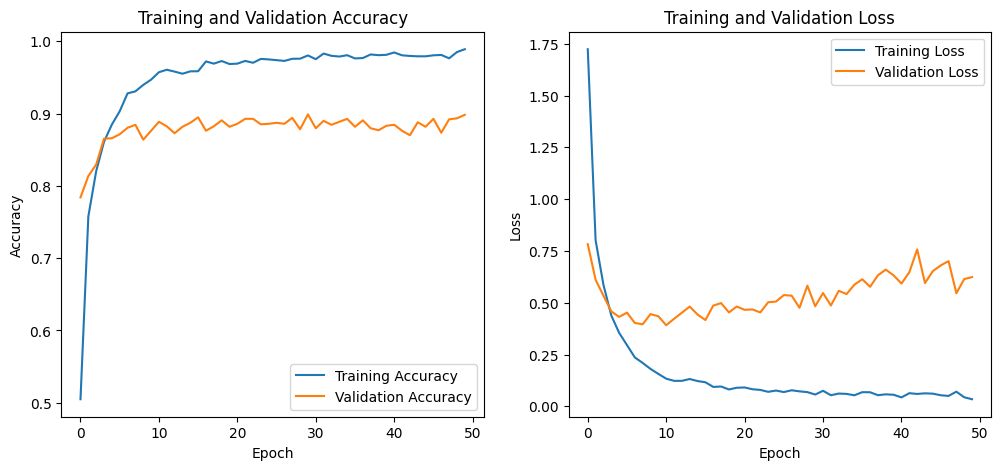

In [27]:
# --- Visualisasi Hasil Pelatihan ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
# --- Evaluasi Mendalam Model ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns # Untuk visualisasi confusion matrix
import matplotlib.image as mpimg

print("\n--- Evaluasi Mendalam Model ---")

# 1. Mengumpulkan Prediksi dan Label Sebenarnya dari Validation Set
y_true = []
y_pred_probs = [] # menyimpan probabilitas prediksi

for images, labels in val_ds.unbatch():
    y_true.append(labels.numpy())
    img_batch = tf.expand_dims(images, axis=0)
    y_pred_probs.append(model.predict(img_batch)[0])

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_classes = np.argmax(y_pred_probs, axis=1) # mengambil ideks prob tertinggi



--- Evaluasi Mendalam Model ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━

In [29]:
  # Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


Classification Report:
                                                                      precision    recall  f1-score   support

   Ayam Geprek (1 potong) = 394 kkal (62% lemak, 12% karb, 27% prot)       0.91      0.94      0.92        63
   Ayam goreng (1 potong) = 391 kkal (50% lemak, 16% karb, 34% prot)       0.86      0.81      0.83        53
          Bakso (1 porsi) = 218 kkal (60% lemak, 15% karb, 25% prot)       0.96      0.87      0.91        52
        Batagor (1 porsi) = 400 kkal (43% lemak, 40% karb, 17% prot)       0.88      0.78      0.83        59
     Bika Ambon (1 potong) = 185 kkal (15% lemak, 80% karb, 5% prot)       0.93      1.00      0.96        37
          Cendol (1 porsi) = 465 kkal (36% lemak, 59% karb, 5% prot)       0.96      0.98      0.97        46
   Dadar Gulung (1 potong) = 139 kkal (43% lemak, 49% karb, 8% prot)       0.97      0.92      0.95        38
       Gorengan (1 potong) = 137 kkal (75% lemak, 19% karb, 6% prot)       0.93      0.96      


Membuat Confusion Matrix...


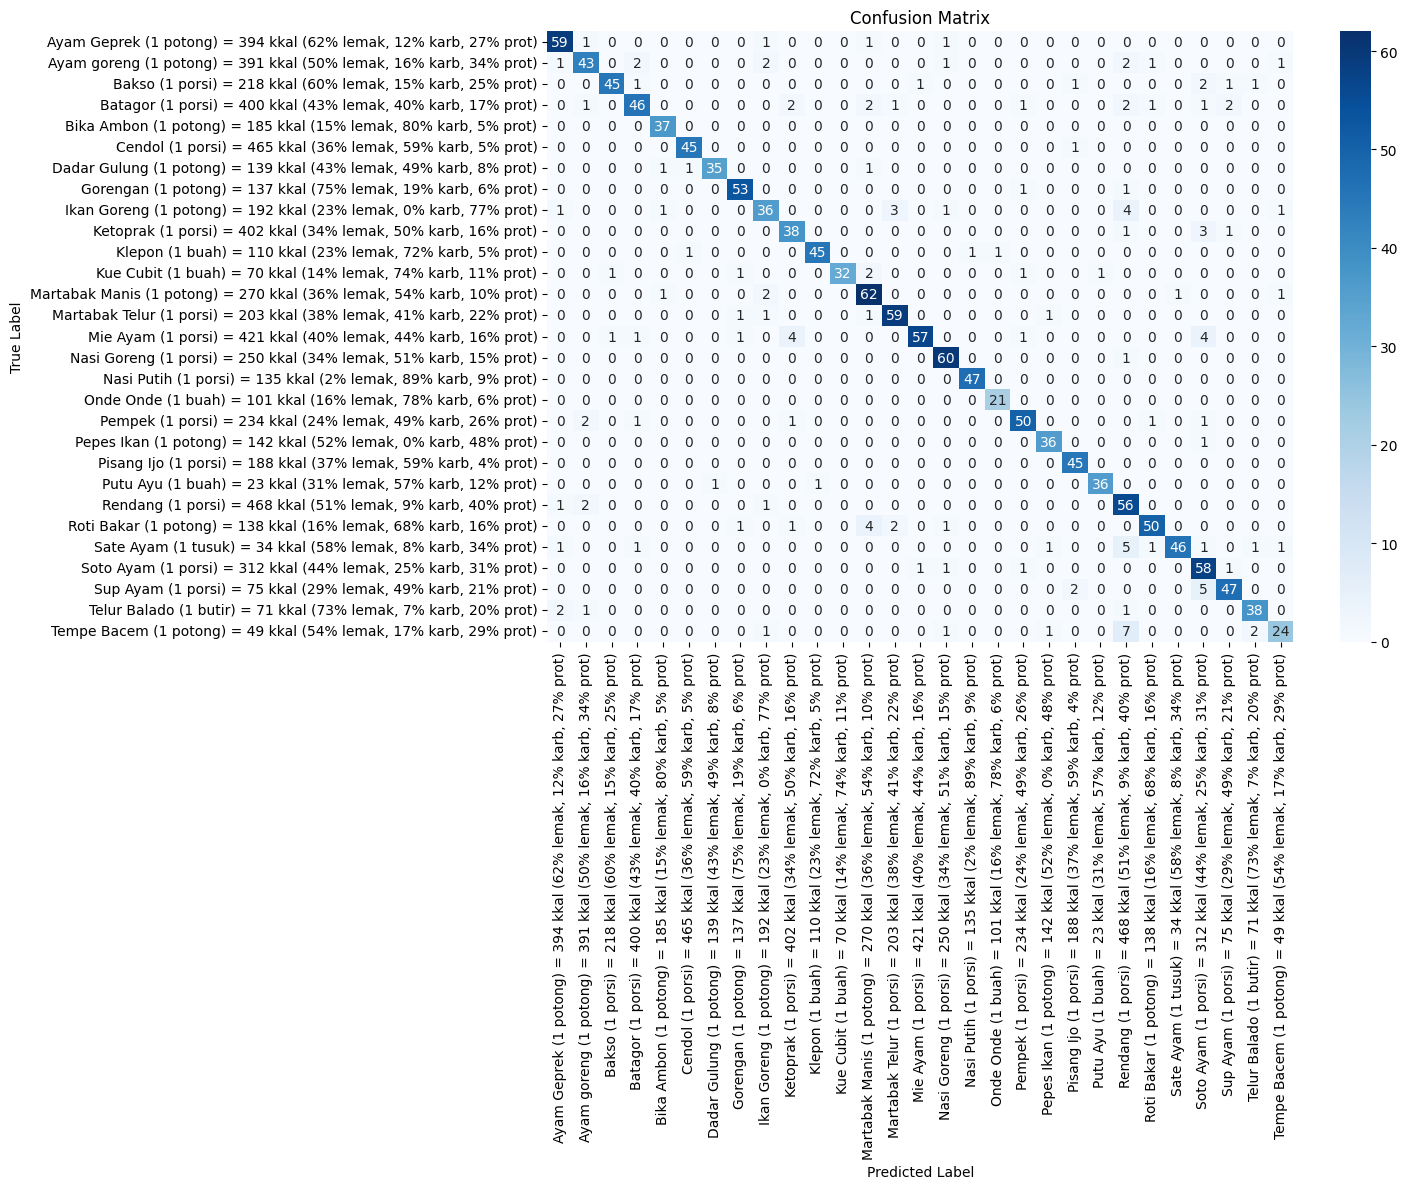

In [30]:
# Visualisasi Confusion Matrix
print("\nMembuat Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



--- Analisis Contoh Kesalahan ---
Mencari contoh gambar yang salah diklasifikasikan...
Ditemukan 148 gambar yang salah diklasifikasikan.


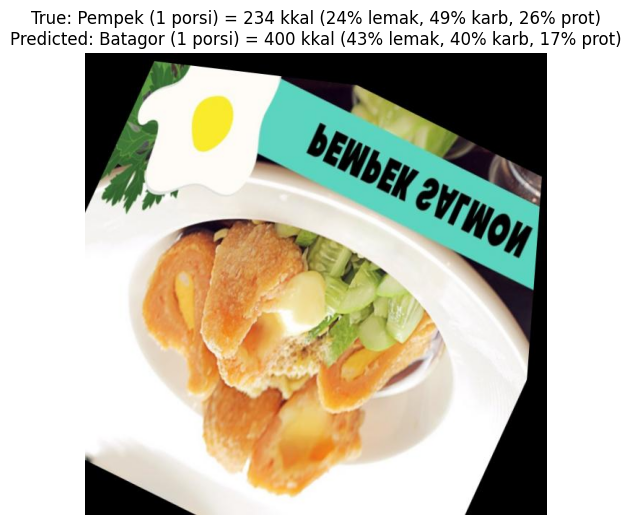

Gambar: /content/Capstone-Project-ML/Dataset Makanan/Pempek (1 porsi) = 234 kkal (24% lemak, 49% karb, 26% prot)/pempek_119_jpg.rf.8063712f87f778149632465835026f0b.jpg
True: Pempek (1 porsi) = 234 kkal (24% lemak, 49% karb, 26% prot), Predicted: Batagor (1 porsi) = 400 kkal (43% lemak, 40% karb, 17% prot)



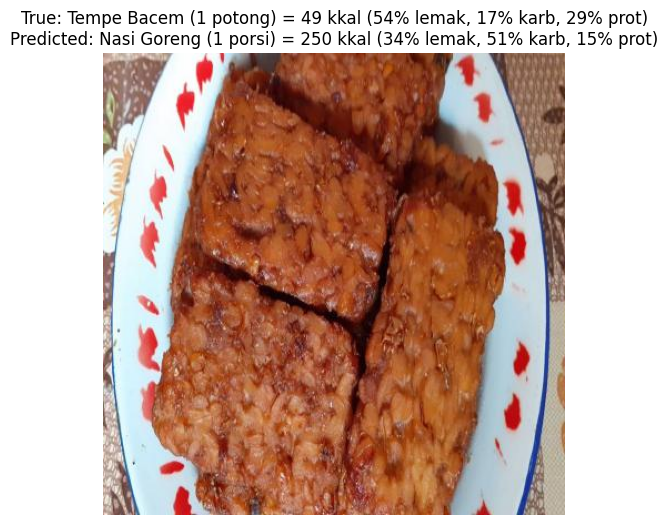

Gambar: /content/Capstone-Project-ML/Dataset Makanan/Tempe Bacem (1 potong) = 49 kkal (54% lemak, 17% karb, 29% prot)/6_tempe_bacem_11_jpg.rf.ad27b50dfd607c72e00c5aa7249e4032.jpg
True: Tempe Bacem (1 potong) = 49 kkal (54% lemak, 17% karb, 29% prot), Predicted: Nasi Goreng (1 porsi) = 250 kkal (34% lemak, 51% karb, 15% prot)



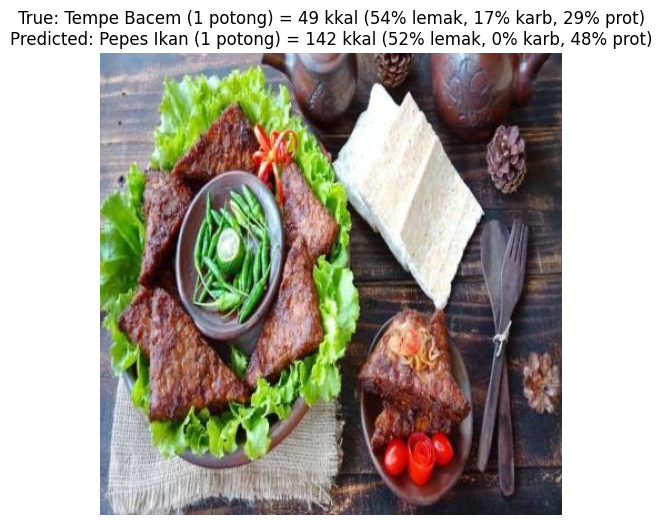

Gambar: /content/Capstone-Project-ML/Dataset Makanan/Tempe Bacem (1 potong) = 49 kkal (54% lemak, 17% karb, 29% prot)/6_tempe_bacem_102_jpg.rf.5031e2546ec3714ea436924439cbf537.jpg
True: Tempe Bacem (1 potong) = 49 kkal (54% lemak, 17% karb, 29% prot), Predicted: Pepes Ikan (1 potong) = 142 kkal (52% lemak, 0% karb, 48% prot)



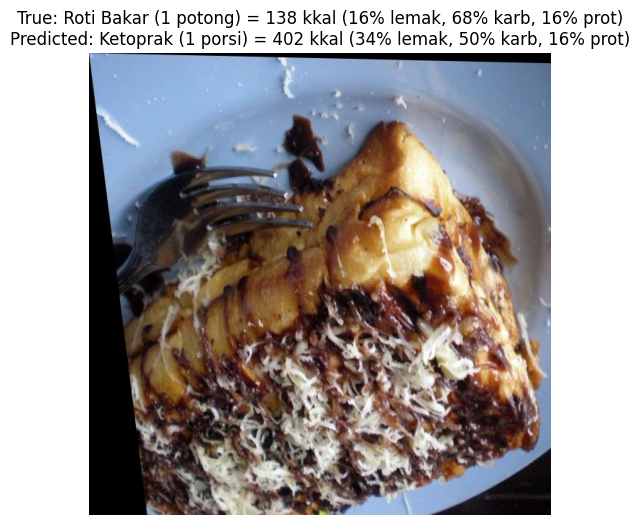

Gambar: /content/Capstone-Project-ML/Dataset Makanan/Roti Bakar (1 potong) = 138 kkal (16% lemak, 68% karb, 16% prot)/roti_bakar_18_jpg.rf.2ac72bfe33c296b038dfb9db567ae072.jpg
True: Roti Bakar (1 potong) = 138 kkal (16% lemak, 68% karb, 16% prot), Predicted: Ketoprak (1 porsi) = 402 kkal (34% lemak, 50% karb, 16% prot)



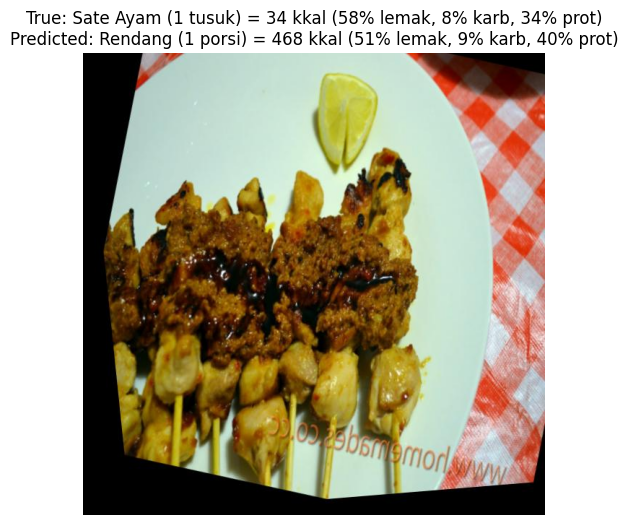

Gambar: /content/Capstone-Project-ML/Dataset Makanan/Sate Ayam (1 tusuk) = 34 kkal (58% lemak, 8% karb, 34% prot)/sate_ayam_39_jpg.rf.1853a663beda84ef74fde8f2a0959d6c.jpg
True: Sate Ayam (1 tusuk) = 34 kkal (58% lemak, 8% karb, 34% prot), Predicted: Rendang (1 porsi) = 468 kkal (51% lemak, 9% karb, 40% prot)



In [31]:
# --- Analisis Contoh Kesalahan ML ----
print("\n--- Analisis Contoh Kesalahan ---")
print("Mencari contoh gambar yang salah diklasifikasikan...")

# Dapatkan indeks gambar yang salah diklasifikasikan
misclassified_indices = np.where(y_true != y_pred_classes)[0]

if len(misclassified_indices) > 0:
    print(f"Ditemukan {len(misclassified_indices)} gambar yang salah diklasifikasikan.")
    # Tampilkan beberapa contoh
    num_display_errors = min(5, len(misclassified_indices)) # Tampilkan maksimal 5 kesalahan

    error_paths = []
    error_true_labels = []
    error_predicted_labels = []

    for i in range(num_display_errors):
        idx_in_val_set = misclassified_indices[i]
        original_path = val_paths[idx_in_val_set]
        true_label = class_names[y_true[idx_in_val_set]]
        predicted_label = class_names[y_pred_classes[idx_in_val_set]]

        plt.figure(figsize=(6, 6))
        img = mpimg.imread(original_path)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
        plt.axis('off')
        plt.show()
        print(f"Gambar: {original_path}\nTrue: {true_label}, Predicted: {predicted_label}\n")

else:
    print("Tidak ada gambar yang salah diklasifikasikan di validation set!")

In [32]:
# --- Menguji Model dan Melihat Persentase Keberhasilan ---
print(f"\nEvaluasi pada data validasi:")
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Persentase Keberhasilan (Validation Accuracy): {val_accuracy*100:.2f}%")


Evaluasi pada data validasi:
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9013 - loss: 0.6550
Validation Loss: 0.6237
Persentase Keberhasilan (Validation Accuracy): 89.82%


In [33]:
# Menyimpan model dalam saved_model
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

In [40]:
# Menyimpan model dalam tensoflow.js
!tensorflowjs_converter --input_format=tf_saved_model --saved_model_tags=serve saved_model tfjs_model

2025-05-31 15:28:22.866288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748705302.887807   74836 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748705302.894091   74836 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-31 15:28:30.014181: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1748705310.014374   74836 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [41]:
# Menyimpan model dalam tensorflow lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [42]:
# Download model yang telah disimpan dalam berbagai format
!zip -r saved_model.zip saved_model
!zip -r tfjs_model.zip tfjs_model
!zip -r model.tflite.zip model.tflite

from google.colab import files
files.download('saved_model.zip')
files.download('tfjs_model.zip')
files.download('model.tflite.zip')

  adding: saved_model/ (stored 0%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/saved_model.pb (deflated 92%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 77%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard1of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: tfjs_model/model.json (deflated 96%)
  adding: model.tflite (deflated 82%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>